[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/forallx94/KoBERT_EC/blob/main/KoBERT.ipynb)

In [1]:
# 필요한 모듈을 설치합니다
!pip install mxnet-cu101
!pip install gluonnlp pandas tqdm
!pip install sentencepiece==0.1.85
!pip install transformers
!pip install torch #원래 ==1.3.1

#SKT에서 공개한 KoBERT 모델을 불러옵니다 
!pip install git+https://git@github.com/SKTBrain/KoBERT.git@master

     |████████████████████████████████| 356.7MB 36kB/s 
  Found existing installation: graphviz 0.10.1
    Uninstalling graphviz-0.10.1:
      Successfully uninstalled graphviz-0.10.1
     |████████████████████████████████| 348kB 6.6MB/s 
  Created wheel for gluonnlp: filename=gluonnlp-0.10.0-cp37-cp37m-linux_x86_64.whl size=595706 sha256=02466e155e3f9e8205e5af43f781680af8988b0863d7eb3d34b3238f9cbf0b21
  Stored in directory: /root/.cache/pip/wheels/37/65/52/63032864a0f31a08b9a88569f803b5bafac8abd207fd7f7534
Successfully built gluonnlp
     |████████████████████████████████| 1.0MB 7.4MB/s 
     |████████████████████████████████| 2.3MB 8.7MB/s 
     |████████████████████████████████| 3.3MB 48.1MB/s 
     |████████████████████████████████| 901kB 48.3MB/s 
  Cloning https://****@github.com/SKTBrain/KoBERT.git (to revision master) to /tmp/pip-req-build-9xn8bq2a
  Running command git clone -q 'https://****@github.com/SKTBrain/KoBERT.git' /tmp/pip-req-build-9xn8bq2a
  Created wheel for kobert

# 1. 데이터 불러오기, 데이터 전처리

In [2]:
import pandas as pd
df = pd.read_excel('./EC_data/감정_분류_데이터셋(전체).xlsx')

Angry = df[df.Emotion == 'Angry']
Neutral = df[df.Emotion == 'Neutral']
Happiness = df[df.Emotion == 'Happiness']
Sadness = df[df.Emotion == 'Sadness']
Fear = df[df.Emotion == 'Fear']
Surprise = df[df.Emotion == 'Surprise']
Disgust= df[df.Emotion == 'Disgust']

In [3]:
Emotion_list = df.Emotion.unique()

In [4]:
Sadness.head()

,Unnamed: 0,Sentence,Emotion
15,19428,학생들은 더우면 얼마든지 물을 마실 수 있으며ㅋㅋㅋㅋㅋㅋㅋㅋㄱ,Sadness
19,869,오늘이 발표날인데 나한테 연락이 없더라고. 그래서 알아봤더니 내 이름이 없대.,Sadness
29,5904,가족들도 모두 슬퍼하고 있어.,Sadness
34,8628,응. 3년 전에 친구 소개로 만났어. 너무 좋았는데 이제까지 싸운적도 없었어.,Sadness
50,2654,어제 밤 샌 작업해서 완성한 기획안을 상사한테 제출했어. 상사가 기획안을 보더니 다...,Sadness


In [5]:
#전처리를 위한 함수
def preprocessing(data):
  import re
  dt = data['Sentence'].copy() #문장만 선택
  dt = dt.dropna() #결측치 제거
  dt = dt.drop_duplicates() #중복 제거
  sentences = dt.tolist()
  new_sent=[]
  for i in range(len(sentences)):
    sent = sentences[i] 
    if type(sent) != str: # 문장 중 str 아닌 것 처리
      sent = str(sent)
    if len(sent) < 2: continue #길이 1 이상인 것만 선택
    sent = re.sub('ㅋㅋ+','ㅋㅋ',sent)
    sent = re.sub('ㅠㅠ+','ㅠㅠ',sent)
    sent = re.sub('ㅇㅇ+','ㅇㅇ',sent) 
    sent = re.sub('ㄷㄷ+','ㄷㄷ',sent) 
    sent = re.sub('ㅎㅎ+','ㅎㅎ',sent)
    sent = re.sub('ㅂㅂ+','ㅂㅂ',sent) 
    sent = re.sub(';;;+',';;',sent)
    sent = re.sub('!!!+','!!',sent)
    sent = re.sub('~+','~',sent)
    sent = re.sub('[?][?][?]+','??',sent) 
    sent = re.sub('[.][.][.]+','...',sent) 
    sent = re.sub('[-=+,#/:$@*\"※&%ㆍ』\\‘|\(\)\[\]\<\>`\'…》]','',sent)
    new_sent.append(sent)
  dt = pd.DataFrame(pd.Series(new_sent), columns=['Sentence'])
  dt['Emotion'] = data['Emotion'].iloc[0]
  return dt

In [6]:
Angry = preprocessing(Angry)
Neutral = preprocessing(Neutral)
Happiness = preprocessing(Happiness)
Sadness = preprocessing(Sadness)
Fear = preprocessing(Fear)
Surprise = preprocessing(Surprise)
Disgust= preprocessing(Disgust)

In [7]:
less_one = ['',118811]
for i in [Angry, Neutral, Happiness, Sadness, Fear, Surprise, Disgust]:
  print('레이블 결과', i['Emotion'][0],len(i))
  if less_one[1] > len(i):
    less_one[1] = len(i)
    less_one[0] = i['Emotion'][0]

print(f'최소 데이터: {less_one[0]} {less_one[1]}')

레이블 결과 Angry 14911
레이블 결과 Neutral 47553
레이블 결과 Happiness 7144
레이블 결과 Sadness 18293
레이블 결과 Fear 6843
레이블 결과 Surprise 9932
레이블 결과 Disgust 6693
최소 데이터: Disgust 6693


In [8]:
# 일부 데이터를 버리면서 균형잡힌 훈련 test acc : 0.611
sentence_train = pd.concat([globals()[emotion_name][1000:6600] for emotion_name in Emotion_list], axis=0, ignore_index=True)
sentence_eval = pd.concat([globals()[emotion_name][:1000] for emotion_name in Emotion_list], axis=0, ignore_index=True)

# 데이터 전체를 사용하되 불균형 상황의 훈련 test acc : 0.568
# sentence_train = pd.concat([globals()[emotion_name][1000:] for emotion_name in Emotion_list], axis=0, ignore_index=True)
# sentence_eval = pd.concat([globals()[emotion_name][:1000] for emotion_name in Emotion_list], axis=0, ignore_index=True)

for i in Emotion_list:
  print('sentence_train',i,len(sentence_train[sentence_train['Emotion'] == i]))
print('-------------------------')
for i in Emotion_list:
  print('sentence_eval',i,len(sentence_eval[sentence_eval['Emotion'] == i]))

sentence_train Angry 5600
sentence_train Neutral 5600
sentence_train Happiness 5600
sentence_train Sadness 5600
sentence_train Fear 5600
sentence_train Surprise 5600
sentence_train Disgust 5600
-------------------------
sentence_eval Angry 1000
sentence_eval Neutral 1000
sentence_eval Happiness 1000
sentence_eval Sadness 1000
sentence_eval Fear 1000
sentence_eval Surprise 1000
sentence_eval Disgust 1000


In [9]:
#모델에 입력하기 위해 형식을 맞춰줍니다
def label(x):
  emotion = ['Angry', 'Neutral', 'Happiness', 'Sadness', 'Fear', 'Surprise', 'Disgust']
  emotion_dict = {key:num for num,key in enumerate(emotion)}
  return emotion_dict[x]

sentence_train["Emotion"] = sentence_train["Emotion"].apply(label)

dtls = [list(sentence_train.iloc[i,:]) for i in range(len(sentence_train))]
dtls[:10] #형식이 통일되었습니다

[['이야기는 해봤는데 어떻게 해야할지 모르겠어. 정말 힘들어.', 0],
 ['이제 주방장 데려다가 선동질이냐? ㄴㄱ ㅈㅃㅈㄴ', 0],
 ['멘탈갑 뻔뻔하다', 0],
 ['순시리 해외 돈이 십조다 !', 0],
 ['911테러는 회사일이냐? 이런..아우!', 0],
 ['전화가 오면 받아야죠. 그럼 안 받아요?', 0],
 ['약속 있어서 친구 기다리고 있는데 친구가 너무 안온다.', 0],
 ['소는 누가키우냐 매일 대모질이사하고 이 개들아', 0],
 ['응. 이쁘다고 사놓고 조금만 크면 안 이쁘니까 버리고 병들어서 버리고. 아휴 왜 그러는지 모르겠어.', 0],
 ['유기견 다큐멘터리를 봤는데 책임감 없는 사람들 때문에 너무 화가 나.', 0]]

# 2. 모델 투입 준비

In [10]:
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import gluonnlp as nlp
import numpy as np
from tqdm import tqdm, tqdm_notebook
from tqdm.notebook import tqdm

from kobert.utils import get_tokenizer 
from kobert.pytorch_kobert import get_pytorch_kobert_model 

from transformers import AdamW 
from transformers import get_linear_schedule_with_warmup

In [11]:
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [12]:
##GPU 사용 시
device = torch.device("cuda:0")

In [13]:
bertmodel, vocab = get_pytorch_kobert_model()

[██████████████████████████████████████████████████]
[██████████████████████████████████████████████████]


In [14]:
#koBERT의 토크나이저를 사용합니다
tokenizer = get_tokenizer()
tok = nlp.data.BERTSPTokenizer(tokenizer, vocab, lower=False)

using cached model


In [15]:
class BERTDataset(Dataset):
    def __init__(self, dataset, sent_idx, label_idx, bert_tokenizer, max_len,
                 pad, pair):
        transform = nlp.data.BERTSentenceTransform(
            bert_tokenizer, max_seq_length=max_len, pad=pad, pair=pair)

        self.sentences = [transform([i[sent_idx]]) for i in dataset]
        self.labels = [np.int32(i[label_idx]) for i in dataset]

    def __getitem__(self, i):
        return (self.sentences[i] + (self.labels[i], ))

    def __len__(self):
        return (len(self.labels))


In [16]:
class BERTClassifier(nn.Module):
    def __init__(self,
                 bert,
                 hidden_size = 768,
                 num_classes=7,
                 dr_rate=None,
                 params=None):
        super(BERTClassifier, self).__init__()
        self.bert = bert
        self.dr_rate = dr_rate
                 
        self.classifier = nn.Linear(hidden_size , num_classes)
        if dr_rate:
            self.dropout = nn.Dropout(p=dr_rate)
    
    def gen_attention_mask(self, token_ids, valid_length):
        attention_mask = torch.zeros_like(token_ids)
        for i, v in enumerate(valid_length):
            attention_mask[i][:v] = 1
        return attention_mask.float()

    def forward(self, token_ids, valid_length, segment_ids):
        attention_mask = self.gen_attention_mask(token_ids, valid_length)
        
        output = self.bert(input_ids = token_ids, token_type_ids = segment_ids.long(), attention_mask = attention_mask.float().to(token_ids.device))
        pooler = output[1]
        
        if self.dr_rate:
            out = self.dropout(pooler)
        return self.classifier(out)

# 3. 학습

In [17]:
## Setting parameters
max_len = 64
batch_size = 64
warmup_ratio = 0.1
num_epochs = 1
max_grad_norm = 1 
log_interval = 200 
learning_rate =  5e-5

In [18]:
# train, validation, test set을 나눠주세요
from sklearn.model_selection import train_test_split

dataset_train, dataset_test = train_test_split(dtls, test_size=0.2, random_state=123)

In [19]:
data_train = BERTDataset(dataset_train, 0, 1, tok, max_len, True, False)
data_test = BERTDataset(dataset_test, 0, 1, tok, max_len, True, False)

train_dataloader = torch.utils.data.DataLoader(data_train, batch_size=batch_size, num_workers=5)
test_dataloader = torch.utils.data.DataLoader(data_test, batch_size=batch_size, num_workers=5)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [20]:
#모델을 만들고 GPU 사용 설정을 해줍니다
model = BERTClassifier(bertmodel,  dr_rate=0.5).to(device)

In [21]:
# Prepare optimizer and schedule (linear warmup and decay)
no_decay = ['bias', 'LayerNorm.weight']
optimizer_grouped_parameters = [
    {'params': [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01},
    {'params': [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
]

In [22]:
#옵티마이저와 손실함수 설정
optimizer = AdamW(optimizer_grouped_parameters, lr=learning_rate)
loss_fn = nn.CrossEntropyLoss()

t_total = len(train_dataloader) * num_epochs
warmup_step = int(t_total * warmup_ratio)

scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=warmup_step,  num_training_steps = t_total)

#정확도를 계산하기 위한 함수
def calc_accuracy(X,Y):
    max_vals, max_indices = torch.max(X, 1)
    train_acc = (max_indices == Y).sum().data.cpu().numpy()/max_indices.size()[0]
    return train_acc

In [23]:
#학습 과정
for e in range(num_epochs):
    train_acc = 0.0
    test_acc = 0.0
    model.train()
    for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(tqdm(train_dataloader)):
        optimizer.zero_grad() 
        token_ids = token_ids.long().to(device) 
        segment_ids = segment_ids.long().to(device) 
        valid_length= valid_length 
        label = label.long().to(device) 
        out = model(token_ids, valid_length, segment_ids) 
        loss = loss_fn(out, label) 
        loss.backward() 
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm) 
        optimizer.step() 
        scheduler.step()  # Update learning rate schedule 
        train_acc += calc_accuracy(out, label)  
        if batch_id % log_interval == 0: 
            print("epoch {} batch id {} loss {} train acc {}".format(e+1, batch_id+1, loss.data.cpu().numpy(), train_acc / (batch_id+1))) 
    print("epoch {} train acc {}".format(e+1, train_acc / (batch_id+1))) 
    model.eval() #모델 평가 부분 
    for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(tqdm(test_dataloader)):
        token_ids = token_ids.long().to(device)
        segment_ids = segment_ids.long().to(device)
        valid_length= valid_length
        label = label.long().to(device)
        out = model(token_ids, valid_length, segment_ids)
        test_acc += calc_accuracy(out, label)
    print("epoch {} test acc {}".format(e+1, test_acc / (batch_id+1)))

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


epoch 1 batch id 1 loss 2.0327110290527344 train acc 0.21875
epoch 1 batch id 201 loss 1.4019228219985962 train acc 0.37632151741293535
epoch 1 batch id 401 loss 1.1738853454589844 train acc 0.4696461970074813

epoch 1 train acc 0.4922512755102041



epoch 1 test acc 0.6022611788617886


In [24]:
# 차후 사용을 위해 학습된 모델을 저장했습니다
torch.save(model.state_dict(), './kobert_balance.pt')

#4 평가

In [25]:
##################################################
# 평가용 Test_set을 모델에 입력하기 위해 형식을 맞춰줍니다
def label(x):
  emotion = ['Angry', 'Neutral', 'Happiness', 'Sadness', 'Fear', 'Surprise', 'Disgust']
  emotion_dict = {key:num for num,key in enumerate(emotion)}
  return emotion_dict[x]

sentence_eval["Emotion"] = sentence_eval["Emotion"].apply(label)

dtls_eval = [list(sentence_eval.iloc[i,:]) for i in range(len(sentence_eval))]

data_test = BERTDataset(dtls_eval, 0, 1, tok, max_len, True, False)
test_dataloader = torch.utils.data.DataLoader(data_test, batch_size=batch_size, num_workers=5)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [26]:
# 해당 데이터에 대해 분류를 시작합니다
model.eval()
answer=[]
train_acc = 0.0
test_acc = 0.0
for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(tqdm_notebook(test_dataloader)):
  token_ids = token_ids.long().to(device)
  segment_ids = segment_ids.long().to(device)
  valid_length= valid_length
  label = label.long().to(device)
  out = model(token_ids, valid_length, segment_ids)
  max_vals, max_indices = torch.max(out, 1)
  answer.append(max_indices.cpu().clone().numpy())
  test_acc += calc_accuracy(out, label)
print('정답률: ',test_acc / (batch_id+1))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))



정답률:  0.6028882575757575


# 5 KoGPT2 chatbot answer 감정 평가

In [27]:
import pandas as pd
import gluonnlp as nlp
from tqdm import tqdm_notebook

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader

from kobert.utils import get_tokenizer 
from kobert.pytorch_kobert import get_pytorch_kobert_model 

In [28]:
# Gpu 설정
device = "cuda" if torch.cuda.is_available() else "cpu"

In [29]:
# KoBERT 설정
bertmodel, vocab = get_pytorch_kobert_model()

using cached model
using cached model


In [30]:
#koBERT의 토크나이저를 사용
tokenizer = get_tokenizer()
tok = nlp.data.BERTSPTokenizer(tokenizer, vocab, lower=False)

using cached model


In [31]:
## Setting parameters
max_len = 64
batch_size = 64
warmup_ratio = 0.1
num_epochs = 1
max_grad_norm = 1 
log_interval = 200 
learning_rate =  5e-5

In [32]:
# 데이터 load
answer_df = pd.read_excel('./EC_data/df4_5_excel.xlsx')
dtls = [[i] for i in answer_df['Answer']]

In [33]:
class BERT_test_Dataset(Dataset):
    def __init__(self, dataset, sent_idx, bert_tokenizer, max_len, pad, pair):
        transform = nlp.data.BERTSentenceTransform(
            bert_tokenizer, max_seq_length=max_len, pad=pad, pair=pair)

        self.sentences = [transform([i[sent_idx]]) for i in dataset]

    def __getitem__(self, i):
        return (self.sentences[i])

    def __len__(self):
        return (len(self.sentences))

In [34]:
data_test = BERT_test_Dataset(dtls, 0, tok, max_len, True, False)
test_dataloader = torch.utils.data.DataLoader(data_test, batch_size=batch_size, num_workers=5)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [35]:
class BERTClassifier(nn.Module):
    def __init__(self,
                 bert,
                 hidden_size = 768,
                 num_classes=7,
                 dr_rate=None,
                 params=None):
        super(BERTClassifier, self).__init__()
        self.bert = bert
        self.dr_rate = dr_rate
                 
        self.classifier = nn.Linear(hidden_size , num_classes)
        if dr_rate:
            self.dropout = nn.Dropout(p=dr_rate)
    
    def gen_attention_mask(self, token_ids, valid_length):
        attention_mask = torch.zeros_like(token_ids)
        for i, v in enumerate(valid_length):
            attention_mask[i][:v] = 1
        return attention_mask.float()

    def forward(self, token_ids, valid_length, segment_ids):
        attention_mask = self.gen_attention_mask(token_ids, valid_length)
        
        output = self.bert(input_ids = token_ids, token_type_ids = segment_ids.long(), attention_mask = attention_mask.float().to(token_ids.device))
        pooler = output[1]
        
        if self.dr_rate:
            out = self.dropout(pooler)
        return self.classifier(out)

In [36]:
model = BERTClassifier(bertmodel,  dr_rate=0.005).to(device)
model.load_state_dict(torch.load('./kobert_balance.pt'))

<All keys matched successfully>

In [37]:
# 해당 데이터에 대해 분류를 시작합니다
model.eval()
answer=[]
train_acc = 0.0
test_acc = 0.0
for batch_id, (token_ids, valid_length, segment_ids) in enumerate(tqdm_notebook(test_dataloader)):
  token_ids = token_ids.long().to(device)
  segment_ids = segment_ids.long().to(device)
  valid_length= valid_length
  out = model(token_ids, valid_length, segment_ids)
  max_vals, max_indices = torch.max(out, 1)
  answer.append(max_indices.cpu().clone().numpy())

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [38]:
emotion = ['Angry', 'Neutral', 'Happiness', 'Sadness', 'Fear', 'Surprise', 'Disgust']
emotion_dict = {num:key for num,key in enumerate(emotion)}

a_emotion = []
for a_emotion_array in answer:
  a_emotion += [emotion_dict[i] for i in a_emotion_array]

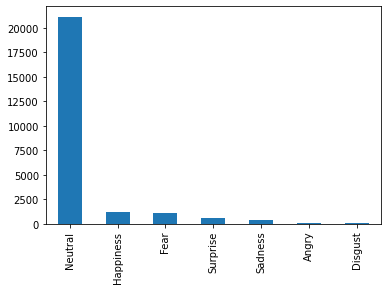

In [39]:
pd.Series(a_emotion).value_counts().plot.bar()

In [40]:
answer_df['A_Emotion'] = a_emotion
answer_df.to_excel('./df4_5_excel.xlsx')

repo : https://github.com/afnf33/emoTale 